# Appendix

## Bruna's Spectral GCN


Let's first implement Bruna's spectral GCN.

In [1]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import scipy.sparse.linalg as slinalg

class BrunaGraphConv(nn.Module):
    """
    Bruna's Spectral Graph Convolution Layer

    This implementation follows the original formulation by Joan Bruna et al.,
    using the eigendecomposition of the graph Laplacian for spectral convolution.
    """

    def __init__(self, in_features, out_features, n_nodes):
        """
        Initialize the Bruna Graph Convolution layer

        Args:
            in_features (int): Number of input features
            out_features (int): Number of output features
        """
        super(BrunaGraphConv, self).__init__()

        self.in_features = in_features
        self.out_features = out_features

        # Learnable spectral filter parameters
        self.weight = nn.Parameter(
            torch.FloatTensor(in_features, out_features, n_nodes-1)
        )

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize weights using Glorot initialization"""
        nn.init.xavier_uniform_(self.weight)


    @staticmethod
    def get_laplacian_eigenvectors(adj):
        """
        Compute eigendecomposition of the normalized graph Laplacian

        Args:
            adj: Adjacency matrix

        Returns:
            eigenvalues, eigenvectors of the normalized Laplacian
        """
        # Compute normalized Laplacian
        # Add self-loops
        adj = adj + sp.eye(adj.shape[0])

        # Compute degree matrix
        deg = np.array(adj.sum(axis=1))
        Dsqrt_inv = sp.diags(1.0 / np.sqrt(deg).flatten())

        # Compute normalized Laplacian: D^(-1/2) A D^(-1/2)
        laplacian = sp.eye(adj.shape[0]) - Dsqrt_inv @ adj @ Dsqrt_inv

        # Compute eigendecomposition
        # Using k=adj.shape[0]-1 to get all non-zero eigenvalues
        eigenvals, eigenvecs = slinalg.eigsh(laplacian.tocsc(), k=adj.shape[0]-1,which='SM', tol=1e-6)

        return torch.FloatTensor(eigenvals), torch.FloatTensor(eigenvecs)

    def forward(self, x, eigenvecs):
        """
        Forward pass implementing Bruna's spectral convolution

        Args:
            x: Input features [num_nodes, in_features]
            eigenvecs: Eigenvectors of the graph Laplacian [num_nodes, num_nodes-1]

        Returns:
            Output features [num_nodes, out_features]
        """
        # Transform to spectral domain
        x_spectral = torch.matmul(eigenvecs.t(), x)  # [num_nodes-1, in_features]

        # Initialize output tensor
        out = torch.zeros(x.size(0), self.out_features, device=x.device)

        # For each input-output feature pair
        for i in range(self.in_features):
            for j in range(self.out_features):
                # Element-wise multiplication in spectral domain
                # This is the actual spectral filtering operation
                filtered = x_spectral[:, i] * self.weight[i, j, :]  # [num_spectrum]

                # Transform back to spatial domain and accumulate
                out[:, j] += torch.matmul(eigenvecs, filtered)

        return out

Next, we will train the model on the karate club network to predict the given node labels indicating nodes' community memberships. We load the data by

In [2]:
import networkx as nx
import torch
import matplotlib.pyplot as plt

# Load karate club network
G = nx.karate_club_graph()
adj = nx.to_scipy_sparse_array(G)
features = torch.eye(G.number_of_nodes())
labels = torch.tensor([G.nodes[i]['club'] == 'Officer' for i in G.nodes()], dtype=torch.long)

We apply the convolution twice with ReLu activation in between. This can be implemented by preparing two independent `BrunaGraphConv` layers, applying them consecutively, and adding a ReLu activation in between.

In [3]:
# Define a simple GCN model
class SimpleGCN(nn.Module):
    def __init__(self, in_features, out_features, hidden_features, n_nodes):
        super(SimpleGCN, self).__init__()
        self.conv1 = BrunaGraphConv(in_features, hidden_features, n_nodes)
        self.relu = nn.ReLU()
        self.conv2 = BrunaGraphConv(hidden_features, out_features, n_nodes)

    def forward(self, x, eigenvecs):
        x = self.conv1(x, eigenvecs)
        x = self.relu(x)
        x = self.conv2(x, eigenvecs)
        return x

We then train the model by

In [4]:
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Get eigenvectors of the Laplacian
eigenvals, eigenvecs = BrunaGraphConv.get_laplacian_eigenvectors(adj)

# Initialize the model
hidden_features = 10
input_features = features.shape[1]
output_features = 2
n_nodes = G.number_of_nodes()
model = SimpleGCN(input_features, output_features, hidden_features, n_nodes)

# Train the model
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Split the data into training and testing sets
train_idx, test_idx = train_test_split(np.arange(G.number_of_nodes()), test_size=0.2, random_state=42)
train_features = features[train_idx]
train_labels = labels[train_idx]
test_features = features[test_idx]
test_labels = labels[test_idx]


n_train = 100
for epoch in range(n_train):
    model.train()
    optimizer.zero_grad()
    output = model(train_features, eigenvecs[train_idx, :])
    loss = criterion(output, train_labels)
    loss.backward()
    optimizer.step()

    # Evaluate the model
    if epoch == 0 or (epoch+1) % 25 == 0:
        model.eval()
        with torch.no_grad():
            output = model(test_features, eigenvecs[test_idx, :])
            _, predicted = torch.max(output, 1)
            accuracy = (predicted == test_labels).float().mean()
            print(f'Epoch {epoch+1}/{n_train}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

Epoch 1/100, Loss: 0.6926, Accuracy: 0.2857


Epoch 25/100, Loss: 0.1350, Accuracy: 0.4286


Epoch 50/100, Loss: 0.0055, Accuracy: 0.2857


Epoch 75/100, Loss: 0.0020, Accuracy: 0.2857


Epoch 100/100, Loss: 0.0014, Accuracy: 0.2857


Observe that the accuracy increases as the training progresses. We can use the model to predict the labels.
The model has a hidden layer, and let's visualize the data in the hidden space.

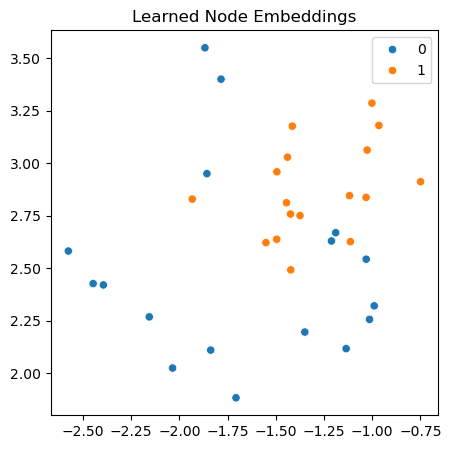

In [5]:
import seaborn as sns
from sklearn.manifold import TSNE

# Visualize the learned embeddings
embeddings = model.conv1(features, eigenvecs).detach().numpy()

xy = TSNE(n_components=2).fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x = xy[:, 0].reshape(-1), y = xy[:, 1].reshape(-1), hue=labels.numpy(), palette='tab10', ax = ax)
ax.set_title("Learned Node Embeddings")
plt.show()

## ChebNet

Let's implement the ChebNet layer.

In [6]:
import numpy as np
import torch
import torch.nn as nn
import scipy.sparse as sp
from typing import Optional


def sparse_mx_to_torch_sparse(sparse_mx):
    """Convert scipy sparse matrix to torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo()
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64)
    )
    values = torch.from_numpy(sparse_mx.data.astype(np.float32))
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse_coo_tensor(indices, values, shape)


class ChebConv(nn.Module):
    """
    Chebyshev Spectral Graph Convolutional Layer
    """

    def __init__(self, in_channels: int, out_channels: int, K: int, bias: bool = True):
        super(ChebConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.K = K

        # Trainable parameters
        self.weight = nn.Parameter(torch.Tensor(K, in_channels, out_channels))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter("bias", None)

        self.reset_parameters()

    def reset_parameters(self):
        """Initialize parameters."""
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def _normalize_laplacian(self, adj_matrix):
        """
        Compute normalized Laplacian L = I - D^(-1/2)AD^(-1/2)
        """
        # Convert to scipy if it's not already
        if not sp.isspmatrix(adj_matrix):
            adj_matrix = sp.csr_matrix(adj_matrix)

        adj_matrix = adj_matrix.astype(float)

        # Compute degree matrix D
        rowsum = np.array(adj_matrix.sum(1)).flatten()
        d_inv_sqrt = np.power(rowsum, -0.5)
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)

        # Compute L = I - D^(-1/2)AD^(-1/2)
        n = adj_matrix.shape[0]
        L = sp.eye(n) - d_mat_inv_sqrt @ adj_matrix @ d_mat_inv_sqrt
        return L

    def _scale_laplacian(self, L):
        """
        Scale Laplacian eigenvalues to [-1, 1] interval
        L_scaled = 2L/lambda_max - I
        """
        try:
            # Compute largest eigenvalue
            eigenval, _ = sp.linalg.eigsh(L, k=1, which="LM", return_eigenvectors=False)
            lambda_max = eigenval[0]
        except:
            # Approximate lambda_max = 2 if eigenvalue computation fails
            lambda_max = 2.0

        n = L.shape[0]
        L_scaled = (2.0 / lambda_max) * L - sp.eye(n)
        return L_scaled

    def chebyshev_basis(self, L_sparse: torch.sparse.Tensor, X: torch.Tensor):
        """
        Compute Chebyshev polynomials basis up to order K.
        """
        # List to store Chebyshev polynomials
        cheb_polynomials = []

        # T_0(L) = I
        cheb_polynomials.append(X)

        if self.K > 1:
            # T_1(L) = L
            X_1 = torch.sparse.mm(L_sparse, X)
            cheb_polynomials.append(X_1)

        # Recurrence T_k(L) = 2L·T_{k-1}(L) - T_{k-2}(L)
        for k in range(2, self.K):
            X_k = (
                2 * torch.sparse.mm(L_sparse, cheb_polynomials[k - 1])
                - cheb_polynomials[k - 2]
            )
            cheb_polynomials.append(X_k)

        return torch.stack(cheb_polynomials, dim=0)  # [K, num_nodes, in_channels]

    def forward(self, X: torch.Tensor, adj_matrix: sp.spmatrix):
        """
        Forward pass.

        Args:
            X: Node features tensor of shape [num_nodes, in_channels]
            adj_matrix: Adjacency matrix in scipy sparse format

        Returns:
            Output tensor of shape [num_nodes, out_channels]
        """
        # Compute normalized and scaled Laplacian
        L_norm = self._normalize_laplacian(adj_matrix)
        L_scaled = self._scale_laplacian(L_norm)

        # Convert to torch sparse tensor
        L_scaled = sparse_mx_to_torch_sparse(L_scaled).to(X.device)

        # Compute Chebyshev polynomials basis
        Tx = self.chebyshev_basis(L_scaled, X)  # [K, num_nodes, in_channels]

        # Perform convolution using learned weights
        out = torch.einsum("kni,kio->no", Tx, self.weight)

        if self.bias is not None:
            out += self.bias

        return out

We stack the layers to form a simple GCN model.

In [7]:
class ChebNet(nn.Module):
    """
    ChebNet model for node classification
    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        K: int,
        num_layers: int,
        dropout: float = 0.5,
    ):
        super(ChebNet, self).__init__()

        self.convs = nn.ModuleList()

        # First layer
        self.convs.append(ChebConv(in_channels, hidden_channels, K))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(ChebConv(hidden_channels, hidden_channels, K))

        # Output layer
        self.convs.append(ChebConv(hidden_channels, out_channels, K))

        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, X: torch.Tensor, adj_matrix: sp.spmatrix):
        """
        Forward pass through all layers
        """
        for i, conv in enumerate(self.convs[:-1]):
            X = conv(X, adj_matrix)
            X = self.activation(X)
            X = self.dropout(X)

        # Output layer
        X = self.convs[-1](X, adj_matrix)
        return X

Let's train the model on the karate club network.

In [8]:
import seaborn as sns
from sklearn.manifold import TSNE

import networkx as nx
import torch
import matplotlib.pyplot as plt

# Load karate club network
G = nx.karate_club_graph()
adj = nx.to_scipy_sparse_array(G)
features = torch.eye(G.number_of_nodes())
labels = torch.tensor(
    [G.nodes[i]["club"] == "Officer" for i in G.nodes()], dtype=torch.long
)

# Initialize the model
hidden_features = 10
input_features = features.shape[1]
output_features = 2
n_nodes = G.number_of_nodes()
K = 3
num_layers = 2
dropout = 0.5

model = ChebNet(
    input_features, hidden_features, output_features, K, num_layers, dropout
)

import torch.optim as optim
from sklearn.model_selection import train_test_split

# Train the model
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Split the data into training and testing sets
train_idx, test_idx = train_test_split(
    np.arange(G.number_of_nodes()), test_size=0.2, random_state=42
)
train_features = features[train_idx]
train_labels = labels[train_idx]
test_features = features[test_idx]
test_labels = labels[test_idx]


n_train = 100
for epoch in range(n_train):
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss = criterion(output[train_idx], train_labels)
    loss.backward()
    optimizer.step()

    # Evaluate the model
    if epoch == 0 or (epoch + 1) % 25 == 0:
        model.eval()
        with torch.no_grad():
            output = model(features, adj)
            _, predicted = torch.max(output[test_idx], 1)
            accuracy = (predicted == test_labels).float().mean()
            print(
                f"Epoch {epoch+1}/{n_train}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}"
            )

Epoch 1/100, Loss: 0.7037, Accuracy: 0.5714
Epoch 25/100, Loss: 0.0825, Accuracy: 0.8571


Epoch 50/100, Loss: 0.0435, Accuracy: 0.8571
Epoch 75/100, Loss: 0.0076, Accuracy: 0.8571


Epoch 100/100, Loss: 0.0032, Accuracy: 0.8571


Let's visualize the learned embeddings.

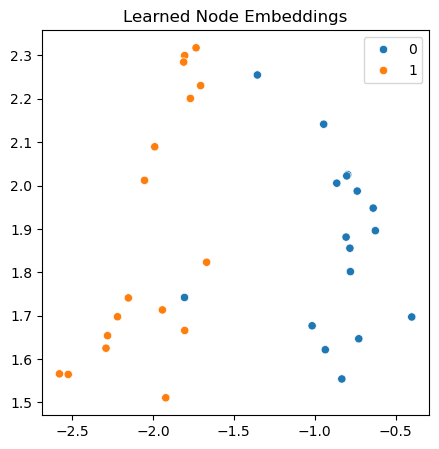

In [9]:
model.eval()
with torch.no_grad():
    # Get embeddings from the last hidden layer
    X_hidden = features
    for conv in model.convs[:-1]:
        X_hidden = conv(X_hidden, adj)
        X_hidden = model.activation(X_hidden)

# Reduce dimensionality for visualization
xy = TSNE(n_components=2).fit_transform(X_hidden.numpy())

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    x=xy[:, 0].reshape(-1),
    y=xy[:, 1].reshape(-1),
    hue=labels.numpy(),
    palette="tab10",
    ax=ax,
)
ax.set_title("Learned Node Embeddings")
plt.show()